Step by step approach to running the Dwell Time Prediction Model

Data Preprocessing:

1.	Filter the dataframe to (Vin, Sequence} multiindex format 
2.	Create a daylight column that is one if a trip is during the day and 0 if the trip is at night
3.	Optional: Filter the range of locations to be within the city of Columbus, Ohio.
4.	Remove outliers where trips are less than 5 minutes.

Model Development

1.	Use DB scan to create your clusters.
>* a.	Use gen_dbs_clusters 
>* b.	Decide what eps and min_samples you would like
2.	Plot the DB_Scan clusters
>* a.	Use Plot_clusters to see the various clusters on a geographical map
3.	Train model to predict which cluster a given point belongs to based on either XGBoost or KNN methodology
>* a.	Use train_pred_model to build the optimal model for predicting clusters (Warning: Extremely computationally expensive)
>* b.	Use predicted_cluster_vals to predict the clusters your data belongs to.
4.	Get accuracy measurements for dwell time interval prediction
>* a.	Use interval_pred_accuracy to assess the quality of your model
>>* i.	Use get_interval_pred to connect the dwell time intervals with your associated predicted clusters
>>* ii.	Use accuracy to compare the interval predictions to the actual intervals


In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import sklearn
import sklearn.utils
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
import datetime
from datetime import timedelta
from sklearn.model_selection import cross_val_score, KFold, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier,plot_tree
from sklearn.multioutput import MultiOutputClassifier
from pandas_profiling import ProfileReport
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("/work/Data/newdataset.csv", index_col= [0,1])
df = df.dropna()
df = df.reset_index()
df = df.drop(columns = ["level_0"])
df = df.set_index(["vin","sequence"])
df = df.sort_index()
df.sort_values('dwell time duration (seconds)', ascending = False)
df['datetime'] = pd.to_datetime(df['last'], unit = 's').dt.hour
df['daylight'] = ((df.datetime > 7) & (df.datetime < 19)) * 1
df

first          last  \
vin                              sequence                               
005b420fd9275f080ad79e1c4330357e 1143      1.578927e+09  1.578928e+09   
                                 1145      1.578938e+09  1.578939e+09   
                                 1146      1.578953e+09  1.578954e+09   
008beb5671fb49a92dc0ef9de96979bf 555       1.578443e+09  1.578445e+09   
                                 556       1.578482e+09  1.578484e+09   
...                                                 ...           ...   
ffffe9555b16c2d737f6f2e8616b1e68 644       1.578858e+09  1.578860e+09   
                                 645       1.578877e+09  1.578880e+09   
                                 646       1.578886e+09  1.578887e+09   
                                 647       1.578954e+09  1.578954e+09   
                                 648       1.578955e+09  1.578955e+09   

                                           start_lat  start_long  latitude  \
vin                              sequence                                    
005b420fd9275f080ad79e1c4330357e 1143         41.267     -81.378    41.410   
                                 1145         41.394     -81.413    41.414   
                                 1146         41.409     -81.497    41.379   
008beb5671fb49a92dc0ef9de96979bf 555          40.100     -83.166    40.149   
                                 556          40.149     -82.904    40.100   
...                                              ...         ...       ...   
ffffe9555b16c2d737f6f2e8616b1e68 644          40.178     -82.997    39.943   
                                 645          39.942     -82.827    40.178   
                                 646          40.178     -82.997    40.136   
                                 647          40.136     -82.997    40.150   
                                 648          40.150     -82.997    40.178   

                                           longitude  \
vin                              sequence              
005b420fd9275f080ad79e1c4330357e 1143        -81.500   
                                 1145        -81.504   
                                 1146        -81.427   
008beb5671fb49a92dc0ef9de96979bf 555         -82.904   
                                 556         -83.166   
...                                              ...   
ffffe9555b16c2d737f6f2e8616b1e68 644         -82.827   
                                 645         -82.997   
                                 646         -82.996   
                                 647         -82.997   
                                 648         -82.997   

                                           dwell time duration (seconds)  \
vin                              sequence                                  
005b420fd9275f080ad79e1c4330357e 1143                           8938.025   
                                 1145                          10074.972   
                                 1146                          14185.917   
008beb5671fb49a92dc0ef9de96979bf 555                           45104.446   
                                 556                           37768.558   
...                                                                  ...   
ffffe9555b16c2d737f6f2e8616b1e68 644                            4264.046   
                                 645                           16974.276   
                                 646                            6248.210   
                                 647                           67188.380   
                                 648                             589.747   

                                           datetime  daylight  
vin                              sequence                      
005b420fd9275f080ad79e1c4330357e 1143            15         1  
                                 1145            18         1  
                                 1146            22         0  
008beb5671fb49a92dc0ef9de96979bf 555           

In [3]:
## Geofencing again to only keep points in the city, set boundary coords for mapping

df = df[(df["latitude"] <= 40.5) \
            & (df["latitude"] >= 39.5) \
            & (df["longitude"] >= -84)\
            & (df["longitude"] <= -82.5)]
y_boundaries = max(df['latitude']), min(df['latitude'])
x_boundaries = min(df['longitude']), max(df['longitude'])


In [4]:
## Drop columns that interfere with dbscan clustering
dbs_data = df[['latitude', 'longitude', 'dwell time duration (seconds)','daylight' ]]
dbs_data.head(1)

,,latitude,longitude,dwell time duration (seconds),daylight
vin,sequence,,,,
008beb5671fb49a92dc0ef9de96979bf,555,40.149,-82.904,45104.446,0


In [5]:
## Drop values with dwell times shorter than 5 minutes, drop dwell times with values greater than 200000
dbs_data = dbs_data[dbs_data["dwell time duration (seconds)"] >= 300]
dbs_data = dbs_data[dbs_data["dwell time duration (seconds)"] <= 200000]
dbs_data.sort_values('dwell time duration (seconds)', ascending = False)

,,latitude,longitude,dwell time duration (seconds),daylight
vin,sequence,,,,
9033f867c45fa1c1d012618c12cb151c,517,40.065,-83.182,198417.194,0
6ae4777dfd345edab79e8c7c92578a33,66,40.119,-83.070,197617.719,0
f43f8e1926cc96f17d3c8f4d8d659dcb,67,39.986,-83.064,197571.994,0
1a09a210968e732766df2090b9273a7e,1076,40.069,-82.517,197263.569,0
1b7dd7dc301db346717ae7c31d3b8447,84,40.103,-83.162,197040.850,0
...,...,...,...,...,...
2d6c9aa04685c968f09bfbbca1cc0649,950,40.108,-83.016,300.295,0
70ffa0a0faa2cdfef5585d31085ad786,484,40.110,-83.019,300.283,1
0e03252bf67bdb84e7eaaa759bf9e03e,634,40.121,-83.033,300.177,1


<AxesSubplot:xlabel='dwell time duration (seconds)', ylabel='Count'>

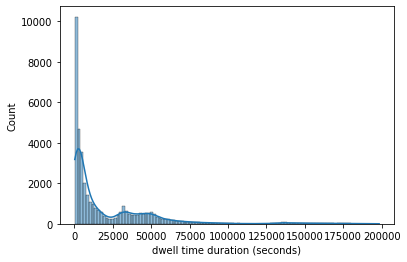

In [6]:
sns.histplot(data = dbs_data, x = 'dwell time duration (seconds)', kde = True)

<AxesSubplot:xlabel='daylight', ylabel='Count'>

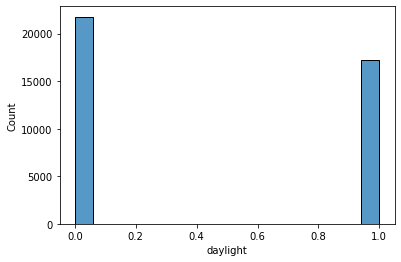

In [7]:
sns.histplot(data = dbs_data, x = 'daylight')

In [8]:

def gen_dbs_clusters(df1, eps, min_samples):
    """ 
    Generates the clusters based off of location and dwell time using DBScan
    
    Parameters:
    _ _ _ _ _ _ _ _ _ _ _ _ _ 
        df1 = DataFrame, containing lat, long, dwell time interval
        eps = Float, epsilon value for DBScan 
        min_sample = Integer, mininimum number of samples in a given cluster for DBScan
       
    
    Returns
    _ _ _ _ _ _ _ _ _ _ _ _ _
        A DataFrame containing lat, long, dwell time interval, associated DBS Cluster
    
    """ 

    df = df1.copy()
    ## eps .14, .2, .17
    ## min_samples = 2,3,4,5
    scaled = StandardScaler().fit_transform(df)
    dbs = DBSCAN(eps = eps, min_samples = min_samples).fit(df)
    labels = dbs.labels_
    df['dbs_cluster'] = labels
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(n_clusters, 'clusters')
    n_noise = list(labels).count(-1)
    print(n_noise, 'noisey values')
    # n_clusters, "clusters"
    n_noise, 'noisey values'
    
    return df
# eps_vals = [.2, .15]

In [9]:

def plot_clusters(df1):
    """ 
    Plots the DBScan clusters on a geographical map
    
    Parameters:
    _ _ _ _ _ _ _ _ _ _ _ _ _ 
        df1 = DataFrame, containing lat, long, dwell time interval, associated dbs cluster for each point 
       
    
    Returns
    _ _ _ _ _ _ _ _ _ _ _ _ _
        A geographic visualisation of the data points and their associated cluster
    
    """ 
    df = df1.copy()
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    ohio_shape = gpd.read_file('/work/Data/cb_2018_39_bg_500k.zip')
    ax = ohio_shape.boundary.plot(figsize=(15, 15), alpha=0.1,)
    gdf.reset_index().plot(ax = ax,cmap = 'jet', alpha = 0.2,column='dbs_cluster',legend=True)
    plt.xlim(x_boundaries[0], x_boundaries[1])
    plt.ylim(y_boundaries[0], y_boundaries[1])

In [10]:

def gen_bins_pointwise(df1, min_interval, max_interval):
    """ 
    Assigns interval bins with ranges (0, min_interval),(min_interval, max_interval),(max_interval,∞) to each cluster in the inputted DataFrame
    
    Parameters:
    _ _ _ _ _ _ _ _ _ _ _ _ _ 
        df1 = DataFrame, containing lat,long, dwell time duration (seconds)
        min_interval = Integer, minimum interval value  
        max_interval = Integer, maximum interval value 
       
    
    Returns
    _ _ _ _ _ _ _ _ _ _ _ _ _
        A DataFrame containing lat, long, dwell time interval, associated interval bins
    
    """ 
    
    df = df1.copy() 
    df['0-{}hr'.format(min_interval)] = 1* (df["dwell time duration (seconds)"]/3600 <= min_interval)
    df['{}-{}hr'.format(min_interval, max_interval)] = 1* ((df["dwell time duration (seconds)"]/3600 > min_interval) & (df["dwell time duration (seconds)"]/3600 <= max_interval))
    df['+{}hr'.format(max_interval)] = 1 * (df["dwell time duration (seconds)"]/3600 > max_interval)
    return df

476 clusters
6114 noisey values


latitude  longitude  daylight  \
vin                              sequence                                  
008beb5671fb49a92dc0ef9de96979bf 555         40.149    -82.904         0   
                                 556         40.100    -83.166         1   
                                 558         40.149    -82.904         0   
                                 559         40.100    -83.167         1   
                                 561         40.149    -82.904         0   
...                                             ...        ...       ...   
ffabe3f9905f857b5f4c64150c4945f0 128         40.084    -82.840         0   
ffffe9555b16c2d737f6f2e8616b1e68 644         39.943    -82.827         0   
                                 646         40.136    -82.996         0   
                                 647         40.150    -82.997         0   
                                 648         40.178    -82.997         0   

                                           0-3hr  3-6hr  +6hr  dbs_cluster  
vin                              sequence                                   
008beb5671fb49a92dc0ef9de96979bf 555           0      0     1            0  
                                 556           0      0     1            1  
                                 558           0      0     1            0  
                                 559           0      0     1            1  
                                 561           0      0     1            0  
...                                          ...    ...   ...          ...  
ffabe3f9905f857b5f4c64150c4945f0 128           1      0     0           17  
ffffe9555b16c2d737f6f2e8616b1e68 644           1      0     0            3  
                                 646           1      0     0           10  
                                 647           0      0     1           68  
                                 648           1      0     0           80  

[32874 rows x 7 columns]

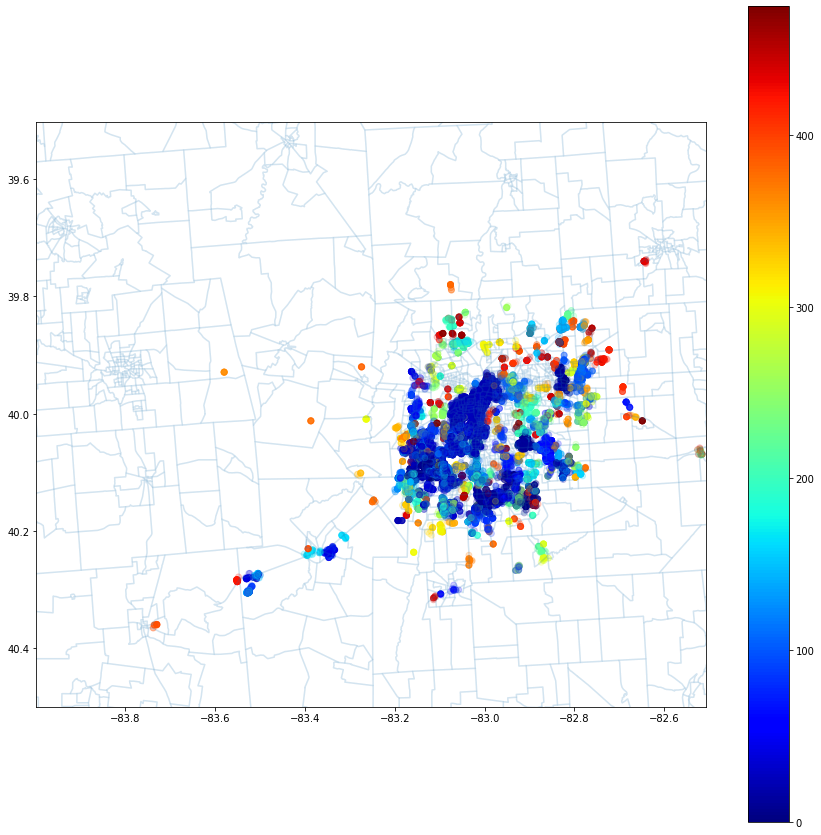

In [133]:
dbs_df = gen_bins_pointwise(dbs_data, 3, 6)

# dbs_df_noiseless = dbs_df.loc[dbs_df['dbs_cluster'] != -1]

# dbs_df.dbs_cluster.value_counts()
dbs_interval = dbs_df.drop(columns = ['dwell time duration (seconds)'])
dbs_interval = gen_dbs_clusters(dbs_interval, .0075, 10)
dbs_interval_noiseless = dbs_interval.loc[dbs_interval['dbs_cluster'] != -1]
plot_clusters(dbs_interval_noiseless)
dbs_interval_noiseless

In [ ]:
def cluster_metrics(df):
    """ 
    
    Generates the clusters based off of location and dwell time using DBScan
    
    Parameters:
    _ _ _ _ _ _ _ _ _ _ _ _ _ 
        df1 = DataFrame, containing lat,long, dwell time interval
        eps = Float, epsilon value for DBScan 
        min_sample = Integer, mininimum number of samples in a given cluster for DBScan
       
    
    Returns
    _ _ _ _ _ _ _ _ _ _ _ _ _
        A DataFrame containing lat, long, dwell time interval, associated DBS Cluster
    
    """ 
    ## Takes in DataFrame with dbs cluster labels and return summary metrics per Cluster
    cluster_hour_info = pd.DataFrame()

    # Grouped by labels to find the average dwell time in hours for each cluster
    cluster_hour_info["avg duration (hr)"] = (df.groupby("dbs_cluster")["dwell time duration (seconds)"].agg('mean'))/3600

    # Grouped by labels to find the median dwell time in hours for each cluster
    cluster_hour_info["median duration (hr)"] = (df.groupby("dbs_cluster")["dwell time duration (seconds)"].agg('median'))/3600

    # Grouped by labels to find the min and max dwell times in hours for each cluster
    cluster_hour_info["min duration (hr)"] = (df.groupby("dbs_cluster")["dwell time duration (seconds)"].agg('min'))/3600
    cluster_hour_info["max duration (hr)"] = (df.groupby("dbs_cluster")["dwell time duration (seconds)"].agg('max'))/3600
    cluster_hour_info["std duration (hr)"] = (df.groupby("dbs_cluster")["dwell time duration (seconds)"].agg('std'))/3600
    cluster_hour_info["cluster size"] = df.groupby("dbs_cluster").size()
    cluster_hour_info.sort_values(by = 'std duration (hr)')
    return cluster_hour_info



In [153]:
def train_pred_model(dbs_df1, knn = True, svm = False):

    """ 
    Trains a provided predictive model on dataset for cluster-prediction.
    Performs hyper-parameter tuning using a randomised Cross-Validaiton Search.

    Parameters:
    _ _ _ _ _ _ _ _ _ _ _ _ _ 
    dbs_df1 = DataFrame, containing lat, long, associated DBS Cluster
    knn = Boolean, specifies if model is knn or not. If not knn, then XGBoost


    Returns
    _ _ _ _ _ _ _ _ _ _ _ _ _
    A trained predictedive model with tuned hyperparameters to predict dbs_cluster, prints CV score.
    BEWARE MAY BE COMPUTATIONALLY EXPENSIVE DUE TO HYPER-PARAMETER TUNING, USE OF GPU ADVISED

    """

    dbs_df = dbs_df1.copy()
    X = dbs_df.loc[: , ['latitude','longitude', 'daylight']]
    y = dbs_df.loc[:, 'dbs_cluster']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
    if svm:
        kf = KFold(4, shuffle=True, random_state=0)
        pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        param_grid = {
            'svc__kernel': ['poly', 'rbf'],
            'svc__coef0' : np.logspace(-2,2,9),
            'svc__degree': [1,2,3,4,5,6],
            'svc__C': np.logspace(-2,2,9),
            'svc__cache_size': [ 12000]
        }
        search = RandomizedSearchCV(pipe, param_grid, cv =kf, n_jobs = -1)
        best_model = search.fit(X_train, y_train)
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        cv_scores = cross_val_score(best_knn,X_train,y_train, cv=3)
        print ("Cross-Validation Accuracies:", cv_scores)
        print ("Overall CV score is:", np.mean(cv_scores))
        return best_model
    if knn:
        print(KNeighborsClassifier().get_params().keys())
        N_grid = range(3,50)
        kf = KFold(4, shuffle=True, random_state=0)
        param_grid = {
        'n_neighbors': N_grid, 
        'algorithm':['ball_tree', 'kd_tree','brute'],
        'p':[1,2, 3,4, 5, 6, 7, 8, 9, 10, 15, 20],
        'leaf_size':np.arange(10,80),
        'weights': ['uniform', 'distance'],
        'n_jobs': [-1]}
        knn = KNeighborsClassifier()
        search = GridSearchCV(knn, param_grid, cv = kf, n_jobs = -1)
        best_model = search.fit(X_train, y_train)
        best_knn = best_model.best_estimator_
        cv_scores = cross_val_score(best_knn,X_train,y_train, cv=3)
        print ("Cross-Validation Accuracies:", cv_scores)
        print ("Overall CV score is:", np.mean(cv_scores))
        return best_knn
    else:
        kf = KFold(4, shuffle=True, random_state=0)
        params = {
                'min_child_weight': range(2,8),
                'eta' : [.3, .2, .1, .05, .01, .005],
                'subsample': [0.65, 0.8, 1.0],
                'gamma': [0.5, 1, 1.5, 2, 3.5, 5],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'max_depth': [3, 4, 5, 7, 10],
                'njobs': [-1]}
        model = XGBClassifier()
        model.get_params().keys()
        search = GridSearchCV(model, params, cv = kf, n_jobs = -1)
        best_model = search.fit(X_train, y_train)
        best_xg = best_model.best_estimator_
        cv_scores = cross_val_score(best_xg,X_train,y_train, cv=3)
        print ("Cross-Validation Accuracies:", cv_scores)
        print ("Overall CV score is:", np.mean(cv_scores))
        return best_xg


def predicted_cluster_vals(df1,best_model):
    """ 
    Fits best_model and predicts the cluster of each datapoint in the dataframe using either KNN or XGBoost
    
    Parameters
    _ _ _ _ _ _ _ _ _ _ _ _ _ 
    df1 = DataFrame, containing lat, long, daylight, dbs_cluster
    pred_model = KNN or XGBoost model


    Returns
    _ _ _ _ _ _ _ _ _ _ _ _ _
    A dataframe containing Lat,Long, predicted_cluster
    """
    X = df1.loc[: , ['latitude','longitude', 'daylight']]
    y = df1.loc[:, 'dbs_cluster']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    best_model = best_model.fit(X_train, y_train)
    pred_df = df1.loc[: , ['latitude','longitude','daylight']]
    pred_df['predicted_cluster'] = best_model.predict(pred_df)
    return pred_df


In [130]:
##CHANGE TO GENERAL CASE FOR INTERVAL BINS (FROM 0-3, 3-6, +6)
def get_interval_pred(pred, actual):
    """ 
    Connects your prediction DataFrame with the associated cluster intervals to retrieve interval bin predictions

    Parameters:
    _ _ _ _ _ _ _ _ _ _ _ _ _ 
    pred = DataFrame, containing lat,long, predicted DBS Cluster
    actual = DataFrame, containing cluster, lat, long, dwell time interval bins


    Returns
    _ _ _ _ _ _ _ _ _ _ _ _ _
    A DataFrame containing lat, long, dwell time interval, associated interval bins (Predictions for interval bins)

    """ 
    actual = dbs_interval_noiseless.drop_duplicates(subset ="dbs_cluster")
    actual = actual.copy()
    pred = pred.copy()
    merged_data = pd.merge(pred.reset_index(),actual,how='inner',left_on=['predicted_cluster'],right_on=['dbs_cluster'])
    merged_data = merged_data.set_index(["vin","sequence"]).sort_index()
    #uncomment the previous line, decide how you want to reset the index. it was working without any reset
    #still need to connect data to a cluster average rather than a random point in the actual dataframe.
    sortedvals = merged_data[["latitude_x","longitude_x","predicted_cluster","0-3hr","3-6hr","+6hr"]]
    return sortedvals.sort_index()

In [129]:
SVM_cluster_predmodel = train_pred_model(dbs_interval_noiseless, knn = False, svm = True)
SVM_cluster_predmodel

In [156]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.2, gamma=2,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.200000003, max_delta_step=0, max_depth=3,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=100, n_jobs=4, njobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [137]:

best_SVC = SVC(kernel= 'poly', degree= 5, coef0= 0.01, cache_size = 12000, C= 31.622776601683793)
best_SVC

SVC(C=31.622776601683793, cache_size=12000, coef0=0.01, degree=5, kernel='poly')

In [132]:
Best_KNN_Model = train_pred_model(dbs_interval_noiseless, knn = True)
Best_KNN_Model

In [141]:
Best_KNN_Model = KNeighborsClassifier(algorithm='kd_tree', leaf_size=69, n_jobs=-1,
                     n_neighbors=20, p=6, weights='distance')

In [138]:
#Add this to get_interval_pred
pred = dbs_interval_noiseless[['latitude', 'longitude', 'daylight']]
actual_clusters_with_intervals = dbs_interval_noiseless.drop_duplicates(subset ="dbs_cluster")
dbs_interval_noiseless

latitude  longitude  daylight  \
vin                              sequence                                  
008beb5671fb49a92dc0ef9de96979bf 555         40.149    -82.904         0   
                                 556         40.100    -83.166         1   
                                 558         40.149    -82.904         0   
                                 559         40.100    -83.167         1   
                                 561         40.149    -82.904         0   
...                                             ...        ...       ...   
ffabe3f9905f857b5f4c64150c4945f0 128         40.084    -82.840         0   
ffffe9555b16c2d737f6f2e8616b1e68 644         39.943    -82.827         0   
                                 646         40.136    -82.996         0   
                                 647         40.150    -82.997         0   
                                 648         40.178    -82.997         0   

                                           0-3hr  3-6hr  +6hr  dbs_cluster  
vin                              sequence                                   
008beb5671fb49a92dc0ef9de96979bf 555           0      0     1            0  
                                 556           0      0     1            1  
                                 558           0      0     1            0  
                                 559           0      0     1            1  
                                 561           0      0     1            0  
...                                          ...    ...   ...          ...  
ffabe3f9905f857b5f4c64150c4945f0 128           1      0     0           17  
ffffe9555b16c2d737f6f2e8616b1e68 644           1      0     0            3  
                                 646           1      0     0           10  
                                 647           0      0     1           68  
                                 648           1      0     0           80  

[32874 rows x 7 columns]

In [154]:
pred_dataframe = predicted_cluster_vals(dbs_interval_noiseless, Best_KNN_Model)


In [81]:
def accuracy(pred_df,actual_df):
    """ 
    Creates an accuracy measurement for the predicted cluster dwell times
    
    Parameters:
    _ _ _ _ _ _ _ _ _ _ _ _ _ 
    pred_df = DataFrame, containing lat,long, predicted DBS Cluster, predicted interval bin
    actual_df = DataFrame, containing cluster, lat, long, dwell time interval bins, actual interval bin


    Returns
    _ _ _ _ _ _ _ _ _ _ _ _ _
    A Float value of the accuracy of the predictions

    """ 
    pred = pred_df[['0-3hr', '3-6hr','+6hr']].values
    actual = actual_df.loc[pred_df.index.values][['0-3hr', '3-6hr','+6hr']].values
    return metrics.accuracy_score(pred, actual)

def interval_pred_accuracy(cluster_pred_df, actual):
    """ 
    Generates interval predictions for predicted clusters and returns accuracy for interval predictions

    Parameters
    _ _ _ _ _ _ _ _ _ _ _ _ _ 
    cluster_pred_df = DataFrame, containing lat, long, predicted DBS Cluster
    actual = DataFrame, containing lat, long, actual DBS Cluster
    


    Returns
    _ _ _ _ _ _ _ _ _ _ _ _ _
    An accuracy score for interval predictions

    """
    pred = get_interval_pred(cluster_pred_df, actual)
    return accuracy(pred, actual)

In [155]:
interval_pred_accuracy(pred_dataframe, dbs_interval_noiseless)


0.7761757011620125

0.7761757011620125 ACCURACY IN PREDICTING DWELL TIME INTERVAL USING KNN

In [ ]:
'http://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf \
https://link.springer.com/article/10.1023%2FA%3A1009745219419 \
https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/' 

In [38]:
## Binary > 10 hours classification, no pre-clustering
dbs_copy = dbs_data.copy()
dbs_copy['more than 10 hr'] = 1 * 1* (dbs_data["dwell time duration (seconds)"]/3600 > 10)
X = dbs_copy.loc[: , ['latitude','longitude']]
y = dbs_copy.loc[:, ['more than 10 hr']]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
kf = KFold(4, shuffle=True, random_state=0)
params = {
        'min_child_weight': range(2,8),
        'eta' : [.3, .2, .1, .05, .01, .005],
        'subsample': [0.65, 0.8, 1.0],
        'gamma': [0.5, 1, 1.5, 2, 3.5, 5],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 7, 10],
        'n_jobs': [-1]}
model = XGBClassifier()
search = RandomizedSearchCV(model, params, cv = kf, n_jobs = -1)
best_model = search.fit(X_train, y_train)
best_xg = best_model.best_estimator_
cv_scores = cross_val_score(best_xg,X_train,y_train, cv=3)
print ("Cross-Validation Accuracies:", cv_scores)
print ("Overall CV score is:", np.mean(cv_scores))

metrics.accuracy_score(best_xg.predict(X_train), y_train)

/root/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[09:12:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/root/venv/lib/python3.9/sit

0.7971341609384084

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=608d4940-9d52-4d53-8e1b-b72eb309e61f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>